### **Link of repo in Github :**


## **Import libraries**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from shapely.geometry import shape, Point
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
import pandas as pd
import geopandas as gpd

import json
from matplotlib import pyplot as plt

## **Create Spark Session**

In [ ]:
# Set the configuration for native Hadoop libraries
spark = SparkSession.builder.appName("MySparkApp").config("spark.hadoop.fs.AbstractFileSystem.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem").getOrCreate()


In [ ]:
spark.conf.set("spark.hadoop.fs.AbstractFileSystem.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")


## ***Extraction***

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

df = spark.read.csv("Sample NYC Data.csv", header=True, inferSchema=True)


In [ ]:
df.show()

+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N| 01-01-13 15:11|  01-01-13 15:18|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|                 N|  06-01-13 0:18|   06-01-13 0:22|              1|      -74.006683|      40.731781|       -73.994499|        40.75066|


## **Preprocessing**

In [ ]:
df1=df.alias('df')

In [ ]:
df1=df1.select("medallion","hack_license","pickup_datetime","dropoff_datetime","passenger_count","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude")

In [ ]:
df1.show()

+--------------------+--------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...| 01-01-13 15:11|  01-01-13 15:18|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|  06-01-13 0:18|   06-01-13 0:22|              1|      -74.006683|      40.731781|       -73.994499|        40.75066|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 05-01-13 18:49|  05-01-13 18:54|              1|      -74.004707|       40.73777|       -74.009834|       40.726002|
|DFD2202EE08F7A8DC...|51EE87E3205C

In [ ]:
df1.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [ ]:
df1.select('passenger_count').describe().toPandas()

,summary,passenger_count
0,count,99999
1,mean,2.1630016300163
2,stddev,1.7398882948433556
3,min,0
4,max,6


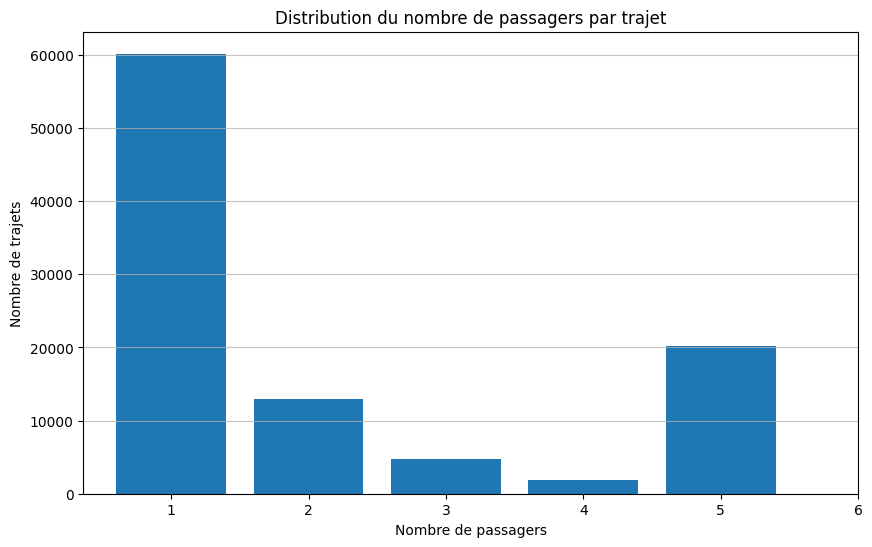

In [ ]:
# Sélectionnez la colonne des passagers
passenger_count = df1.select("passenger_count")

# Convertissez la colonne en liste Python
passenger_count_list = passenger_count.rdd.flatMap(lambda x: x).collect()

# Créez un histogramme
plt.figure(figsize=(10, 6))
plt.hist(passenger_count_list, bins=range(1, 7), align='left', rwidth=0.8)
plt.xlabel("Nombre de passagers")
plt.ylabel("Nombre de trajets")
plt.title("Distribution du nombre de passagers par trajet")
plt.xticks(range(1, 7))
plt.grid(axis='y', alpha=0.75)

# Affichez l'histogramme
plt.show()

In [ ]:
null_counts = df1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])
null_counts.show()

+---------+------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|medallion|hack_license|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+---------+------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|        0|           0|              0|               0|              0|               0|              0|                0|               0|
+---------+------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+



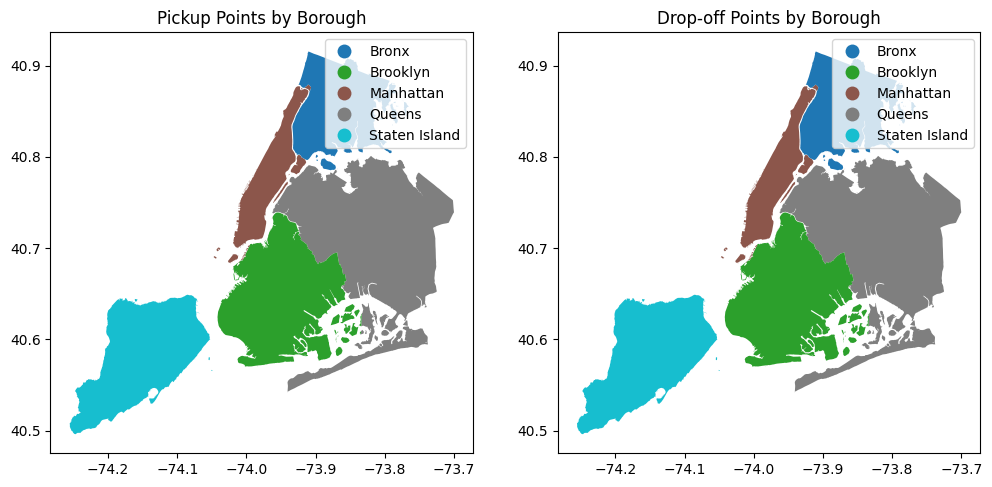

In [ ]:

# Load the 'pickup_boroughs' GeoDataFrame from a file or another source
pickup_boroughs = gpd.read_file("nyc-boroughs.geojson")


# Load the 'dropoff_boroughs' GeoDataFrame from a file or another source
dropoff_boroughs = gpd.read_file("nyc-boroughs.geojson")

# Create subplots for side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot pickup points
pickup_boroughs.plot(column='borough', legend=True, ax=ax[0])
ax[0].set_title("Pickup Points by Borough")

# Plot drop-off points
dropoff_boroughs.plot(column='borough', legend=True, ax=ax[1])
ax[1].set_title("Drop-off Points by Borough")



# Assuming you have the 'pickup_boroughs' and 'dropoff_boroughs' GeoDataFrames


plt.show()

In [ ]:

# Load the GeoJSON file with boroughs using geopandas
gdf = gpd.read_file("nyc-boroughs.geojson")
# Calculate the area of each polygon and add it as a new column
gdf['area'] = gdf.geometry.area

# Sort the GeoDataFrame by area in descending order
sorted_gdf = gdf.sort_values(by='area', ascending=False)
# Define a User Defined Function (UDF) to find the borough for a given point
def get_borough(longitude, latitude):
    point = Point(float(longitude), float(latitude))
    for index, row in sorted_gdf.iterrows():
        if row['geometry'].contains(point):
            return row['borough']
    return "Unknown"

get_borough_udf = udf(get_borough, StringType())

# Create new columns for pickup and drop-off boroughs
df1 = df1.withColumn("pickup_borough", get_borough_udf(df1["pickup_longitude"], df1["pickup_latitude"]))
df1 = df1.withColumn("dropoff_borough", get_borough_udf(df1["dropoff_longitude"], df1["dropoff_latitude"]))

# Show the DataFrame with enriched data
df1.select("pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","pickup_borough","dropoff_borough").show()


/tmp/ipykernel_130/572660766.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['area'] = gdf.geometry.area


+----------------+---------------+-----------------+----------------+--------------+---------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|pickup_borough|dropoff_borough|
+----------------+---------------+-----------------+----------------+--------------+---------------+
|      -73.978165|      40.757977|       -73.989838|       40.751171|     Manhattan|      Manhattan|
|      -74.006683|      40.731781|       -73.994499|        40.75066|     Manhattan|      Manhattan|
|      -74.004707|       40.73777|       -74.009834|       40.726002|     Manhattan|      Manhattan|
|      -73.974602|      40.759945|       -73.984734|       40.759388|     Manhattan|      Manhattan|
|       -73.97625|      40.748528|       -74.002586|       40.747868|     Manhattan|      Manhattan|
|      -73.966743|      40.764252|       -73.983322|       40.743763|     Manhattan|      Manhattan|
|      -73.995804|      40.743977|       -74.007416|       40.744343|     Manhattan|      M

In [ ]:
df1_pandas=df1.toPandas()

In [ ]:
len(df1_pandas)

99999

In [ ]:
condition=df1_pandas["pickup_borough"]=="Unknown"


In [ ]:
df1_pandas_test=df1_pandas[condition]

In [ ]:
df1_pandas_test

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_borough,dropoff_borough
73,DDB3F3E0172B1FBF0C9E39CA773CC6E3,559F071794B7213986693B57DCEDDEE5,07-01-13 22:19,07-01-13 22:39,1,0.0,0.0,0.0,0.0,Unknown,Unknown
95,0428E3DD09EA5A63D85509C7CA8C0199,A4B0B563E94A1C3ADA0B308161EDCB5A,07-01-13 16:19,07-01-13 16:24,1,0.0,0.0,0.0,0.0,Unknown,Unknown
99,DDB3F3E0172B1FBF0C9E39CA773CC6E3,559F071794B7213986693B57DCEDDEE5,07-01-13 18:42,07-01-13 18:49,1,0.0,0.0,0.0,0.0,Unknown,Unknown
100,DDB3F3E0172B1FBF0C9E39CA773CC6E3,559F071794B7213986693B57DCEDDEE5,07-01-13 20:19,07-01-13 20:23,1,0.0,0.0,0.0,0.0,Unknown,Unknown
199,6F70DA82F52A1281E4E6646AE996D25A,4103ADCF50D18CFE25AB616F368A5945,13-01-13 4:38,13-01-13 4:44,2,0.0,0.0,0.0,0.0,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
99759,1E2518C5129CB39312FBC7601C6D20ED,A736098D0C7144E35AA10EDB13F30F32,13-01-13 18:47,13-01-13 18:59,1,0.0,0.0,0.0,0.0,Unknown,Unknown
99825,6F28ECF71E4400A1BBF94EE809238BDC,7A2019218608E584ECA826E19C92851A,13-01-13 19:29,13-01-13 19:39,5,0.0,0.0,0.0,0.0,Unknown,Unknown
99886,D03EFBB5896A151FEB225F5DE544B88E,6FE0B1BAF7C02770543368A3AE37B7C9,13-01-13 19:27,13-01-13 19:34,1,0.0,0.0,0.0,0.0,Unknown,Unknown
99899,BE0396EBC842E52F724D6E724900C117,2A43B8DCB392C65C552DF21BDFE4D70F,13-01-13 17:36,13-01-13 17:36,1,0.0,0.0,0.0,0.0,Unknown,Unknown


#### **Pick_Up_hour/Drop_Off_hour**

In [ ]:
df2=df1.alias("df1")


In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [ ]:
df2=(df2
     # Convert "pickup_datetime" and "dropoff_datetime" columns to timestamp format
     .withColumn("pickup_datetime", F.to_timestamp(F.col("pickup_datetime"), "dd-MM-yy HH:mm"))
     .withColumn("dropoff_datetime",F.to_timestamp(F.col("dropoff_datetime"), "dd-MM-yy HH:mm"))
     # Create "hour_pickup" and "hour_dropoff" columns with "HH:mm" format
     .withColumn("hour_pickup",F.concat(F.lpad(F.hour("pickup_datetime"), 2, '0'),
                                             F.lit(":"),
                                             F.lpad(F.minute("pickup_datetime"), 2, '0')))
     .withColumn("hour_dropoff",F.concat(F.lpad(F.hour("dropoff_datetime"), 2, '0'),
                                             F.lit(":"),
                                             F.lpad(F.minute("dropoff_datetime"), 2, '0')))

     )



In [ ]:
df2.select("pickup_datetime","dropoff_datetime","hour_pickup","hour_pickup").show()

+-------------------+-------------------+-----------+-----------+
|    pickup_datetime|   dropoff_datetime|hour_pickup|hour_pickup|
+-------------------+-------------------+-----------+-----------+
|2013-01-01 15:11:00|2013-01-01 15:18:00|      15:11|      15:11|
|2013-01-06 00:18:00|2013-01-06 00:22:00|      00:18|      00:18|
|2013-01-05 18:49:00|2013-01-05 18:54:00|      18:49|      18:49|
|2013-01-07 23:54:00|2013-01-07 23:58:00|      23:54|      23:54|
|2013-01-07 23:25:00|2013-01-07 23:34:00|      23:25|      23:25|
|2013-01-07 15:27:00|2013-01-07 15:38:00|      15:27|      15:27|
|2013-01-08 11:01:00|2013-01-08 11:08:00|      11:01|      11:01|
|2013-01-07 12:39:00|2013-01-07 13:10:00|      12:39|      12:39|
|2013-01-07 18:15:00|2013-01-07 18:20:00|      18:15|      18:15|
|2013-01-07 15:33:00|2013-01-07 15:49:00|      15:33|      15:33|
|2013-01-08 13:11:00|2013-01-08 13:19:00|      13:11|      13:11|
|2013-01-08 09:50:00|2013-01-08 10:02:00|      09:50|      09:50|
|2013-01-1

## **Number_of_trips_same_borough : Query 3**

In [ ]:
df2.createOrReplaceTempView("taxi_trips")


In [ ]:
trips_within_same_borough = spark.sql("""
    SELECT
        pickup_borough,
        dropoff_borough,
        COUNT(*) AS number_of_trips
    FROM taxi_trips
    WHERE pickup_borough = dropoff_borough
    GROUP BY pickup_borough, dropoff_borough
""")

In [ ]:
trips_within_same_borough.show()

+--------------+---------------+---------------+
|pickup_borough|dropoff_borough|number_of_trips|
+--------------+---------------+---------------+
|     Manhattan|      Manhattan|          83561|
|      Brooklyn|       Brooklyn|           1065|
|        Queens|         Queens|           1396|
|         Bronx|          Bronx|             51|
|       Unknown|        Unknown|           1805|
| Staten Island|  Staten Island|              1|
+--------------+---------------+---------------+



## **Number_of_trips_across_borough : Query 4**

In [ ]:
trips_across_boroughs = spark.sql("""
    SELECT
        pickup_borough,
        dropoff_borough,
        COUNT(*) AS number_of_trips
    FROM taxi_trips
    WHERE pickup_borough <> dropoff_borough
    GROUP BY pickup_borough, dropoff_borough
""")

In [ ]:
trips_across_boroughs.show()

+--------------+---------------+---------------+
|pickup_borough|dropoff_borough|number_of_trips|
+--------------+---------------+---------------+
|      Brooklyn|      Manhattan|            774|
|        Queens|          Bronx|            100|
|         Bronx|         Queens|              2|
| Staten Island|         Queens|              1|
|       Unknown|      Manhattan|            106|
|      Brooklyn|         Queens|            115|
|        Queens|  Staten Island|              2|
|     Manhattan|  Staten Island|              9|
|        Queens|        Unknown|            119|
|     Manhattan|       Brooklyn|           1923|
|       Unknown|         Queens|             18|
|       Unknown|  Staten Island|              1|
|     Manhattan|         Queens|           3943|
|      Brooklyn|        Unknown|             11|
|     Manhattan|          Bronx|            244|
|        Queens|      Manhattan|           3698|
|         Bronx|      Manhattan|             25|
|       Unknown|    

### **Preprocesing : Time Interval calculation for Utilization**


In [ ]:
df3=df2.alias('df2')

In [ ]:
# Define a window specification for partitioning and ordering

windowSpec = Window.partitionBy("medallion","hack_license").orderBy("hour_pickup")


In [ ]:
df3= df3.withColumn("previous_dropoff_time", F.lag(df3["hour_dropoff"]).over(windowSpec))


In [ ]:
# Convert the "heure_debut" and "heure_fin_precedente" columns to Unix timestamps
df3 = df3.withColumn("pickup_hour_unix", unix_timestamp(df3["hour_pickup"], "HH:mm"))
df3 = df3.withColumn("previous_dropoff_time_unix", unix_timestamp(df3["previous_dropoff_time"], "HH:mm"))

# Calculate the difference in hours
df3 = df3.withColumn("diff_hours", (df3["pickup_hour_unix"] - df3["previous_dropoff_time_unix"]) / 3600)

# Drop Unix timestamp columns if necessary
df3 = df3.drop("pickup_hour_unix", "previous_dropoff_time_unix")


In [ ]:
# Remove records with NULL values in the "previous_dropoff_time" column
df3= df3.filter(df3["previous_dropoff_time"].isNotNull())

## **Compute Utilization : Query 1**

In [ ]:
df4=df3.alias('df3')

In [ ]:
# Filter the DataFrame to keep only rows where the "diff_hours" column is less than 4
df4= df4.filter(col("diff_hours") < 4)


In [ ]:
df4_Utilization=df4.alias("df4")

In [ ]:
df4_Utilization= df4_Utilization.groupBy("dropoff_borough").agg({"diff_hours": "sum"})


In [ ]:
df4_Utilization.show()

+---------------+------------------+
|dropoff_borough|   sum(diff_hours)|
+---------------+------------------+
|         Queens|2056.1666666666656|
|        Unknown|  828.566666666667|
|       Brooklyn|1117.6166666666659|
|  Staten Island|0.8666666666666666|
|      Manhattan|21311.666666666628|
|          Bronx| 127.7333333333333|
+---------------+------------------+



## **AVG Time to next Trips : Query2**


In [ ]:
df5=df2.alias("df2")

In [ ]:
# Calculate the time to the next pickup for each row
df5 = df5.withColumn("next_pickup_time", lead("pickup_datetime").over(Window.partitionBy("medallion").orderBy("pickup_datetime")))

# Calculate the time difference in seconds
df5 = df5.withColumn("time_to_next_trip", (unix_timestamp("next_pickup_time") - unix_timestamp("dropoff_datetime")))

# Filter records where the time difference is positive (next trips)
df5 = df5.filter(col("time_to_next_trip") > 0)

# Group by destination borough and calculate the average time to the next trip
df5_avg_time_next_trip = df5.groupBy("dropoff_borough").agg(avg("time_to_next_trip").alias("avg_time_to_next_trip"))


In [ ]:
df5_avg_time_next_trip.show()

+---------------+---------------------+
|dropoff_borough|avg_time_to_next_trip|
+---------------+---------------------+
|         Queens|    6389.721592080841|
|        Unknown|    12310.46313799622|
|       Brooklyn|   6581.6850047154985|
|  Staten Island|              13935.0|
|      Manhattan|   2077.1937111374436|
|          Bronx|    4973.719008264463|
+---------------+---------------------+

